In [1]:
import pandas as pd
import numpy as np 
import re 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint

# Using Wordnet for lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../aftercovid.csv")
df.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,20,Nov,"['freehold', 'semi', 'detached', 'house', '61'...",freehold semi detached house 61 jalan kelawar ...,2020-11-26
1,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...",20,Nov,"['4', '822', 'sq', 'ft', 'unit', 'luxury', 'na...",4 822 sq ft unit luxury nassim park residences...,2020-11-23
2,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,20,Nov,"['vinz', 'wrote', 'hdb', 'oct', '2020', 'get',...",vinz wrote hdb oct 2020 get confirmation eligi...,2020-11-22
3,18-Nov-20,Wrote to HDB in OCT 2020 to get a confirmation...,20,Nov,"['wrote', 'hdb', 'oct', '2020', 'get', 'confir...",wrote hdb oct 2020 get confirmation eligibilit...,2020-11-18
4,28-Oct-20,"Assuming price and location is the same, would...",20,Oct,"['assuming', 'price', 'location', 'would', 'bu...",assuming price location would buy 20 year old ...,2020-10-28


In [3]:
df['clean_text'].head()

0    ['freehold', 'semi', 'detached', 'house', '61'...
1    ['4', '822', 'sq', 'ft', 'unit', 'luxury', 'na...
2    ['vinz', 'wrote', 'hdb', 'oct', '2020', 'get',...
3    ['wrote', 'hdb', 'oct', '2020', 'get', 'confir...
4    ['assuming', 'price', 'location', 'would', 'bu...
Name: clean_text, dtype: object

In [4]:
len(df['clean_text'][0])

474

### Data Cleaning

In [5]:
# remove punc 
df['clean_text']  = df['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df['clean_text']  = df['clean_text'].apply(lambda x: x.lower())
# remove words with length < 2
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# tokenize
df['clean_text']  = [word_tokenize(row) for row in df['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use']
stop_words.extend(new_stop_words)

def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df['clean_text']  = df['clean_text'].apply(lambda x: remove_stopwords(x))

In [6]:
# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['clean_text'] = df['clean_text'].apply(lemmatize_text)

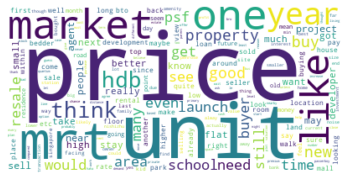

In [7]:
# Word Cloud

description_str = ''
for word_list in df['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '
    
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_before_covid.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### LSA Topic Modelling

#### Prepare Corpus

In [8]:
# de-tokenization
detokenized_doc = df['clean_text'].tolist()

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(detokenized_doc)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = detokenized_doc
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, '100'), (1, '500'), (2, 'agent'), (3, 'appointed'), (4, 'arezone'), (5, 'asking'), (6, 'campaign'), (7, 'detached'), (8, 'edgeprop'), (9, 'estate'), (10, 'forumposting'), (11, 'frank'), (12, 'freehold'), (13, 'frontage'), (14, 'house'), (15, 'jalan'), (16, 'kelawar'), (17, 'knight'), (18, 'land'), (19, 'market'), (20, 'marketing'), (21, 'medium'), (22, 'metre'), (23, 'million'), (24, 'nine'), (25, 'plot'), (26, 'price'), (27, 'property'), (28, 'psf'), (29, 'rate'), (30, 'sale'), (31, 'semi'), (32, 'singapore'), (33, 'sits'), (34, 'sole'), (35, 'storey'), (36, 'translates'), (37, 'two'), (38, 'utm'), (39, '822'), (40, '899'), (41, 'luxury'), (42, 'nassim'), (43, 'park'), (44, 'put'), (45, 'residence'), (46, 'tag'), (47, 'unit'), (48, 'upwards'), (49, '2018')]

Total Vocabulary Size: 17689


#### Hyperparameter Tuning

#### Helpers

In [11]:
def prepare_corpus(doc_clean):

    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model

    return dictionary, doc_term_matrix

In [12]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):

    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = number_of_topics, num_words = words))

    return lsamodel

In [13]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):

    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, chunksize = 100)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = doc_clean, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [14]:
def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [15]:
detokenized_doc = df['clean_text'].tolist()
start, stop, step = 2, 20, 1
plot_graph(detokenized_doc, start, stop, step)

KeyboardInterrupt: 

### Building LSA Model 

In [16]:
number_of_topics = 7
words = 10
model = create_gensim_lsa_model(detokenized_doc, number_of_topics, words)

[(0, '0.303*"price" + 0.258*"unit" + 0.214*"year" + 0.183*"one" + 0.176*"property" + 0.173*"hdb" + 0.170*"market" + 0.149*"like" + 0.148*"buyer" + 0.134*"new"'), (1, '0.485*"year" + 0.409*"rate" + -0.273*"unit" + 0.199*"hdb" + 0.186*"fixed" + 0.184*"interest" + 0.175*"flat" + 0.175*"loan" + -0.172*"mrt" + -0.168*"psf"'), (2, '-0.395*"price" + 0.279*"school" + -0.261*"buyer" + 0.256*"mrt" + -0.246*"property" + -0.223*"agent" + -0.200*"market" + 0.197*"one" + -0.156*"developer" + 0.145*"like"'), (3, '-0.513*"hdb" + -0.460*"flat" + 0.269*"rate" + 0.208*"year" + -0.176*"bto" + 0.156*"psf" + -0.150*"resale" + 0.130*"fixed" + 0.122*"interest" + 0.117*"property"'), (4, '-0.608*"unit" + 0.289*"school" + 0.281*"property" + -0.206*"year" + -0.168*"flat" + -0.146*"psf" + -0.136*"rate" + 0.134*"agent" + 0.101*"buy" + 0.101*"one"'), (5, '-0.449*"unit" + 0.289*"mrt" + -0.276*"agent" + 0.254*"flat" + 0.229*"price" + -0.217*"noise" + 0.166*"new" + 0.144*"bto" + 0.138*"launch" + 0.133*"area"'), (6, '0.

In [17]:
pprint(model.print_topics())

[(0,
  '0.303*"price" + 0.258*"unit" + 0.214*"year" + 0.183*"one" + '
  '0.176*"property" + 0.173*"hdb" + 0.170*"market" + 0.149*"like" + '
  '0.148*"buyer" + 0.134*"new"'),
 (1,
  '0.485*"year" + 0.409*"rate" + -0.273*"unit" + 0.199*"hdb" + 0.186*"fixed" + '
  '0.184*"interest" + 0.175*"flat" + 0.175*"loan" + -0.172*"mrt" + '
  '-0.168*"psf"'),
 (2,
  '-0.395*"price" + 0.279*"school" + -0.261*"buyer" + 0.256*"mrt" + '
  '-0.246*"property" + -0.223*"agent" + -0.200*"market" + 0.197*"one" + '
  '-0.156*"developer" + 0.145*"like"'),
 (3,
  '-0.513*"hdb" + -0.460*"flat" + 0.269*"rate" + 0.208*"year" + -0.176*"bto" + '
  '0.156*"psf" + -0.150*"resale" + 0.130*"fixed" + 0.122*"interest" + '
  '0.117*"property"'),
 (4,
  '-0.608*"unit" + 0.289*"school" + 0.281*"property" + -0.206*"year" + '
  '-0.168*"flat" + -0.146*"psf" + -0.136*"rate" + 0.134*"agent" + 0.101*"buy" '
  '+ 0.101*"one"'),
 (5,
  '-0.449*"unit" + 0.289*"mrt" + -0.276*"agent" + 0.254*"flat" + 0.229*"price" '
  '+ -0.217*"noise

In [18]:
coherence_model_lsa = CoherenceModel(model=model, texts=detokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.377446239920374


<ipython-input-19-41be599fb74d>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_word.loc[df_word.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


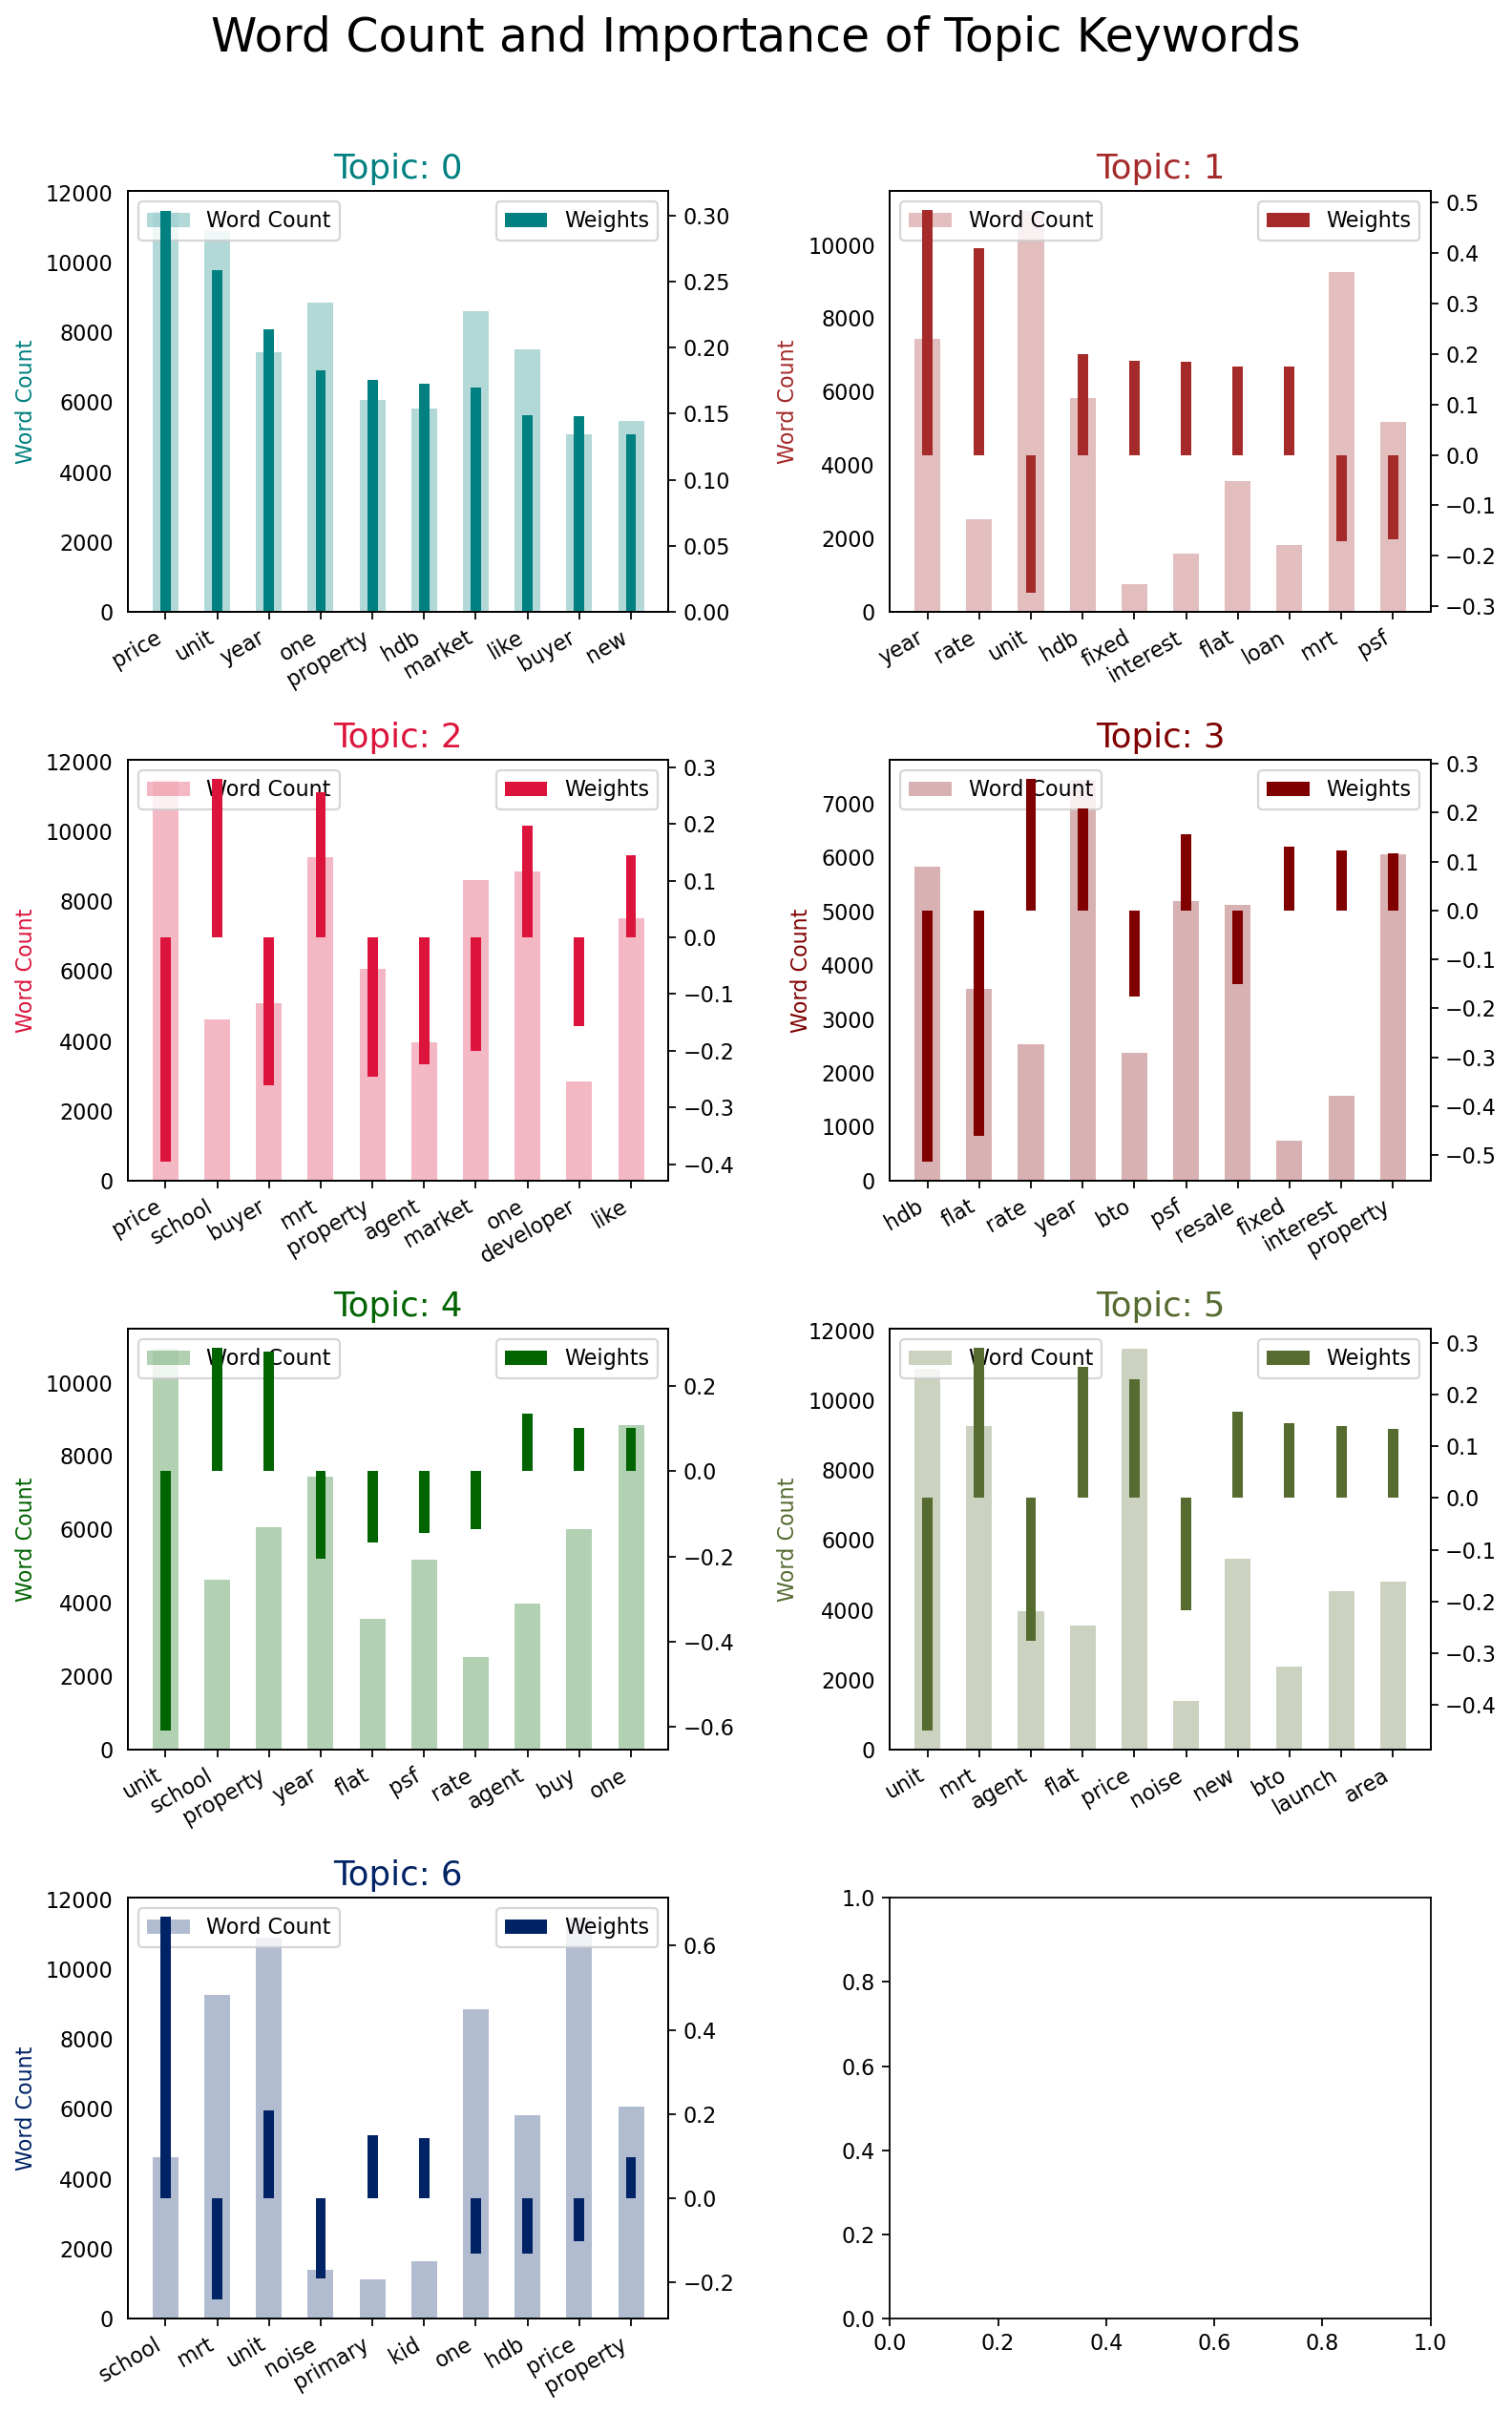

In [19]:
from collections import Counter

data_lemmatized = df['clean_text'].tolist()
topics = model.show_topics(num_topics=number_of_topics, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_word = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > number_of_topics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df_word.loc[df_word.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_word.loc[df_word.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_word.loc[df_word.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lsa_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
